In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.utils import to_categorical

In [37]:
image_dir = r'C:\Users\Daniel\Downloads\imagens'
df = pd.read_csv(r"C:\Users\Daniel\Downloads\HAM10000_metadata.csv")

In [38]:
#preprocessing
def load_images(df, image_dir):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image_id'] + ".jpg")
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array) 
        images.append(img_array)
        labels.append(row['dx'])
    return np.array(images), np.array(labels)


In [39]:
#label
X, y = load_images(df, image_dir)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small


def build_model(num_classes):
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(224, 224, 3),  
        include_top=False,  
        weights='imagenet' 
    )

    base_model.trainable = False

   
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model
num_classes = len(label_encoder.classes_)
model = build_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [55]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 98s 368ms/step - accuracy: 0.6621 - loss: 1.0446 - val_accuracy: 0.7219 - val_loss: 0.7310
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - accuracy: 0.7276 - loss: 0.7498 - val_accuracy: 0.7399 - val_loss: 0.6990
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 89s 354ms/step - accuracy: 0.7583 - loss: 0.6680 - val_accuracy: 0.7678 - val_loss: 0.6535
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.7594 - loss: 0.6466 - val_accuracy: 0.7539 - val_loss: 0.6497
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 330ms/step - accuracy: 0.7838 - loss: 0.5901 - val_accuracy: 0.7649 - val_loss: 0.6397
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 333ms/step - accuracy: 0.7855 - loss: 0.5860 - val_accuracy: 0.7813 - val_loss: 0.5992
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0.7873 - loss: 0.5768 - val_accuracy: 0.7858 - val_loss: 0.5987
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 336ms/step - accuracy: 0.7953 - loss: 0

In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")

63/63 - 8s - 123ms/step - accuracy: 0.7868 - loss: 0.5951
Test Accuracy: 0.7868197560310364


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step


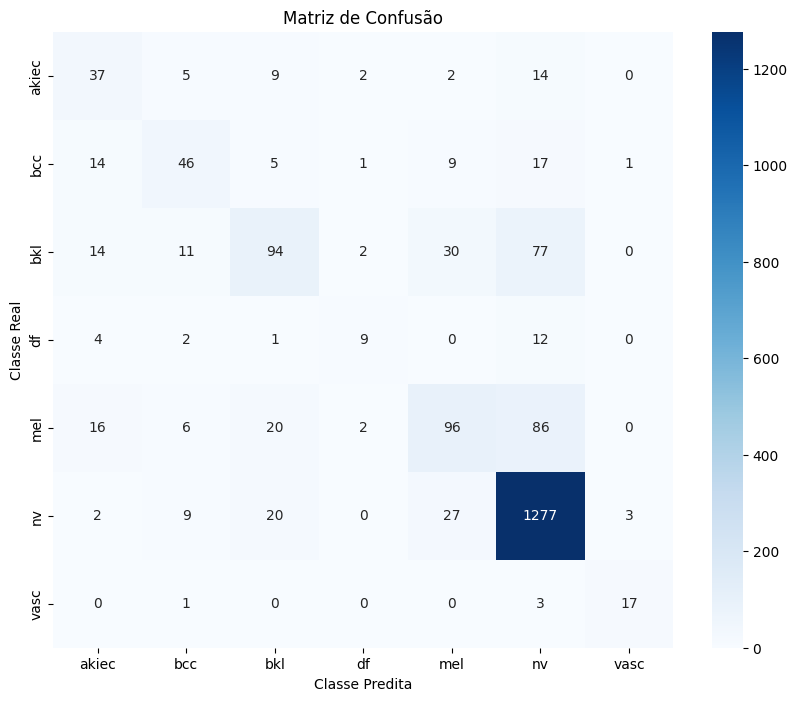

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusão")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Recall para a classe '{class_name}': {recall[i]:.4f}")
plt.show()